In [1]:
import torch
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
import pandas
from dataset import getPerformancesList
%matplotlib inline

In [2]:
SNAPSHOTS_DIR = "/home/pasinducw/Documents/research/university-work-scs-4224/comparing-rnn-params/model/model-snapshots/exp15"
SONGS_DIR = "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_cqt/"

In [3]:
excluded_transforms = [
        "_PITCH_SHIFT_0", "_PITCH_SHIFT_1", "_PITCH_SHIFT_2", "_PITCH_SHIFT_3", "_PITCH_SHIFT_4",
        "_TIME_STRETCH_0", "_TIME_STRETCH_1", "_TIME_STRETCH_2", "_TIME_STRETCH_3", "_TIME_STRETCH_4",
    ]

# Object array of shape {song: string, name: string, path: string} containing the details of performances
PERFORMANCES = getPerformancesList(root_dir = SONGS_DIR, excluded_transforms = excluded_transforms)

In [4]:
# Mark excluded performances

excluded_transforms = [
    "_PITCH_SHIFT_0", "_PITCH_SHIFT_1", "_PITCH_SHIFT_2", "_PITCH_SHIFT_3", "_PITCH_SHIFT_4",
    "_PITCH_SHIFT_5", "_PITCH_SHIFT_6", "_PITCH_SHIFT_7",
    "_TIME_STRETCH_0", "_TIME_STRETCH_1", "_TIME_STRETCH_2", "_TIME_STRETCH_3", "_TIME_STRETCH_4",
    "_TIME_STRETCH_5", "_TIME_STRETCH_6", "_TIME_STRETCH_7",  "_TIME_STRETCH_8",
]
for performance in PERFORMANCES:
    name = performance['name']
    performance['excluded'] = False
    for suffix in excluded_transforms:
        if name[len(name)-len(suffix):] == suffix:
            performance['excluded'] = True

In [5]:
# Checking songs
for performance in PERFORMANCES:
    if performance['excluded'] == True:
        continue
    print(performance['song'], performance['name'])

A_Whiter_Shade_Of_Pale annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale_WAV
A_Whiter_Shade_Of_Pale procol_harum+Greatest_Hits+2-A_Whiter_Shade_Of_Pale_WAV
Abracadabra steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra_WAV
Abracadabra sugar_ray+14_59+11-Abracadabra_WAV
Addicted_To_Love robert_palmer+Riptide+03-Addicted_To_Love_WAV
Addicted_To_Love tina_turner+Tina_Live_In_Europe_CD_1_+09-Addicted_To_Love_WAV
All_Along_The_Watchtower bob_dylan+Before_The_Flood_Disc_Two_+07-All_Along_the_Watchtower_WAV
All_Along_The_Watchtower dave_matthews_band+Live_At_Red_Rocks_8_15_95_Disc_2+08-All_Along_The_Watchtower_WAV
All_Along_The_Watchtower jimi_hendrix_experience+Electric_Ladyland+15-All_Along_The_Watchtower_WAV
All_Along_The_Watchtower u2+Rattle_and_Hum+05-All_Along_The_Watchtower_WAV
All_Tomorrow_s_Parties japan+Quiet_Life+06-All_Tomorrow_s_Parties_WAV
All_Tomorrow_s_Parties velvet_underground+Andy_Warhol_with_Nico_+06-All_Tomorrow_s_Parties_WAV
America paul_simon+Concert_in_the_Park_Disc_

In [6]:
# Array containing the songs
SONGS = []
for performance in PERFORMANCES:
    SONGS.append(performance['song'])
SONGS = np.unique(SONGS)

In [7]:
# Add model parameters to the PERFORMANCES objects
# Resulting object -> { song: string, name: string, path: string, snapshot: OrderedDict, parameters: vector }

for (index, performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    snapshot_location = os.path.join(
        SNAPSHOTS_DIR,
        '{}-{}'.format(index, performance['name']),
        'snapshot-400.pytorch'
    )
    snapshot = torch.load(snapshot_location)['model_state_dict']
    performance['snapshot'] = snapshot # This is an ordered dictionary with model parameters
    
    parameters = None
    for key in snapshot.keys():
        values = snapshot[key].flatten()
        if parameters is None:
            parameters = values
        else:
            parameters = torch.cat((parameters, values))
    performance['parameters'] = parameters # This is a vector that has all the parameters of the model flattened

### Computing cosine similarity

In [8]:
cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for (base_index, base_performance) in enumerate(PERFORMANCES):
    if base_performance['excluded'] == True:
        continue
    similarity_values = []
    for (test_index, test_performance) in enumerate(PERFORMANCES):
        if test_performance['excluded'] == True:
            continue
        base_params = base_performance['parameters'].unsqueeze(0)
        test_params = test_performance['parameters'].unsqueeze(0)
        similarity = cos_similarity(base_params, test_params).squeeze().detach().numpy()
        similarity_values.append(similarity)
    base_performance['similarity_values'] = np.array(similarity_values)

In [9]:
for (index, performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    ranks = np.argsort(-performance['similarity_values'])
    matched_songs = []
    for matched_performance_index in ranks:
        matched_song_index = np.where(SONGS == PERFORMANCES[matched_performance_index]['song'])
        matched_songs.append(matched_song_index[0][0])

    performance['matched_songs'] = matched_songs

In [10]:
# PERFORMANCES[35]['song']
# PERFORMANCES[1]['matched_songs']

In [11]:
def getUnique(items):
    unique_items = []
    for item in items:
        already_there = False
        for existing_item in unique_items:
            if item == existing_item:
                already_there = True
        if not already_there:
            unique_items.append(item)
    return unique_items

def calculateNextOccurrence(performance_index, drop_duplicates=False, match_key='matched_songs'):
    relavant_song_index = PERFORMANCES[performance_index][match_key][0]
    fetched_song_indices = np.where(PERFORMANCES[performance_index][match_key][1:] == relavant_song_index)
    if drop_duplicates:
        fetched_song_indices = np.where(getUnique(PERFORMANCES[performance_index][match_key][1:]) == relavant_song_index)
    return fetched_song_indices[0][0]

In [12]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    occurrence = calculateNextOccurrence(index)
    occurrences.append(occurrence)
np.average(occurrences)

10.042682926829269

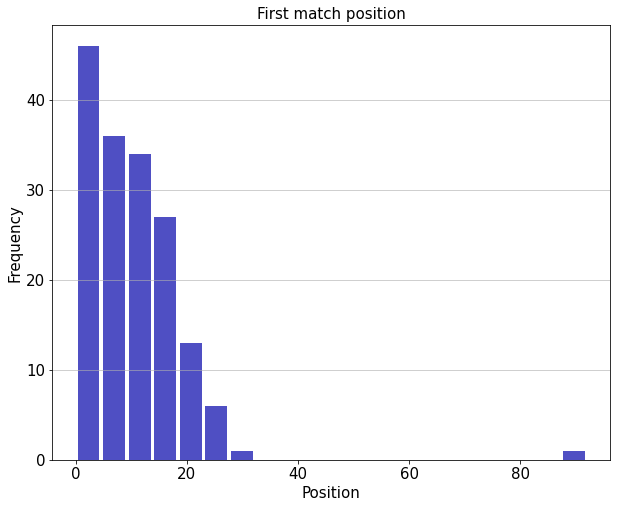

In [13]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Position',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First match position',fontsize=15)
plt.show()

In [14]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    occurrence = calculateNextOccurrence(index, True)
    occurrences.append(occurrence)
np.average(occurrences)

4.414634146341464

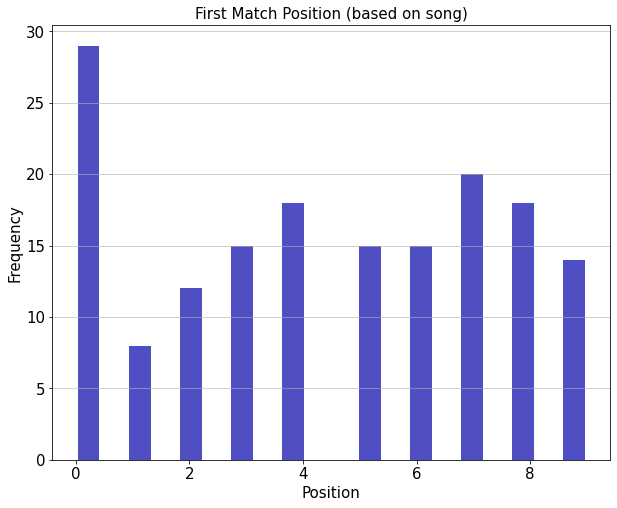

In [15]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Position',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First Match Position (based on song)',fontsize=15)
plt.show()

# Based purely on cosine similarity

In [16]:
length_upper = 42 * 119 + 336
length_lower = 0
CQT_TOP_DROP_BINS: int = 36
print(length_upper)

5334


In [17]:
for performance in PERFORMANCES:
    if performance['excluded'] == True:
        continue
    cqt = np.load(performance['path'])
    frames = cqt
    frames = frames.transpose()
    frames = frames[length_lower:length_upper, :]
    frames = frames[:, :-CQT_TOP_DROP_BINS:]
#     maxIndices = np.argmax(frames, axis=1)
    
#     filteredFrames = np.zeros(frames.shape, dtype=bool)
#     for (step, index) in enumerate(maxIndices):
#         filteredFrames[step, index] = 1.0

#     filteredFrames = filteredFrames[:, :-CQT_TOP_DROP_BINS]
#     print(filteredFrames.shape)
    performance['raw'] = frames.flatten()

In [18]:
cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for (base_index, base_performance) in enumerate(PERFORMANCES):
    if base_performance['excluded'] == True:
        continue
    similarity_values = []
    for (test_index, test_performance) in enumerate(PERFORMANCES):
        if test_performance['excluded'] == True:
            continue
        base_params = torch.from_numpy(base_performance['raw']).type(torch.float32).unsqueeze(0)
        test_params = torch.from_numpy(test_performance['raw']).type(torch.float32).unsqueeze(0)
        similarity = cos_similarity(base_params, test_params).squeeze().detach().numpy()
        similarity_values.append(similarity)
    base_performance['raw_similarity_values'] = np.array(similarity_values)

/tmp/ipykernel_151787/2477872529.py:10: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  base_params = torch.from_numpy(base_performance['raw']).type(torch.float32).unsqueeze(0)


In [19]:
for (index, performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    ranks = np.argsort(-performance['raw_similarity_values'])
    matched_songs = []
    for matched_performance_index in ranks:
        matched_song_index = np.where(SONGS == PERFORMANCES[matched_performance_index]['song'])
        matched_songs.append(matched_song_index[0][0])

    performance['raw_matched_songs'] = matched_songs

In [20]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    occurrence = calculateNextOccurrence(index, match_key='raw_matched_songs')
    occurrences.append(occurrence)
np.average(occurrences)

8.689024390243903

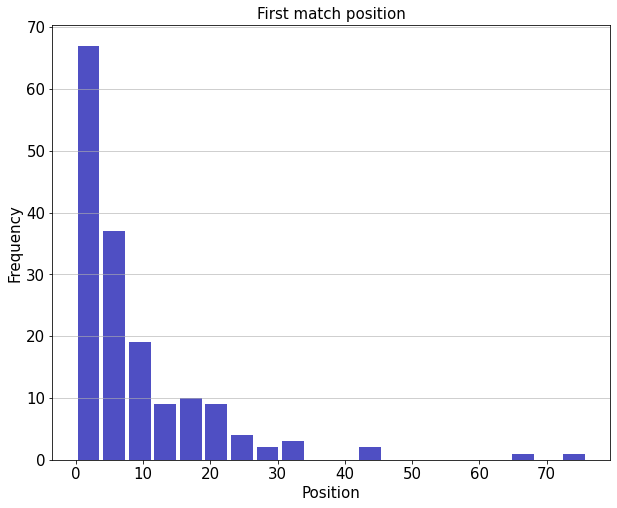

In [21]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Position',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First match position',fontsize=15)
plt.show()

In [22]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    occurrence = calculateNextOccurrence(index, True, match_key='raw_matched_songs')
    occurrences.append(occurrence)
np.average(occurrences)

4.0426829268292686

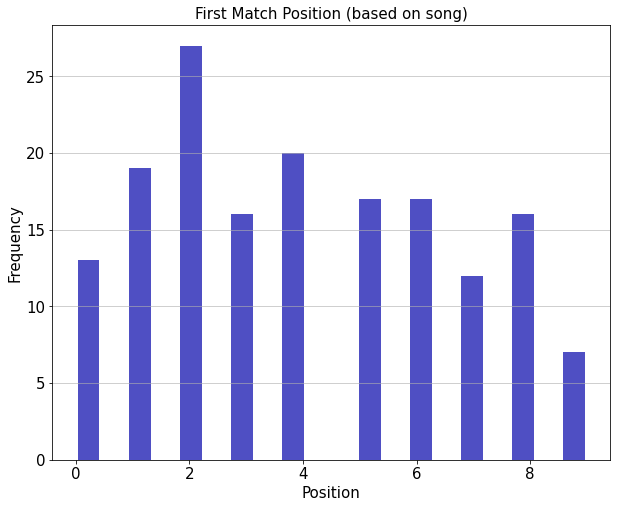

In [23]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Position',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First Match Position (based on song)',fontsize=15)
plt.show()

In [26]:
PERFORMANCES[0]['parameters'].shape

torch.Size([49968])

In [27]:
PERFORMANCES[0]['raw'].shape

(256032,)

In [28]:
frames.shape

(5334, 48)

In [29]:
performance_count = 0
for (index,performance) in enumerate(PERFORMANCES):
    if performance['excluded'] == True:
        continue
    performance_count += 1

print(performance_count)

164
